In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build a vocabulary of unique characters and map them from/to integers
chars = sorted(list(set(''.join(words))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}  # 1-indexed
stoi['.'] = 0  
itos = {i: ch for ch, i in stoi.items()}  # 0-indexed
vocab_size = len(stoi)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# building the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# UTILITES FUNCTIONS

def train_nn():
  # same optimization as last time
  max_steps = 200000
  batch_size = 32
  lossi = []

  for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

def evaluate_nn():
  @torch.no_grad() # this decorator disables gradient tracking
  def split_loss(split):
    x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

  split_loss('train')
  split_loss('val')

def sample_from_nn():
  # sample from the model
  g = torch.Generator().manual_seed(2147483647 + 10)

  for _ in range(20):
      out = []
      context = [0] * block_size # initialize with all ...
      
      while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the end of the word, break
        if ix == 0:
          break
      
      print(''.join(itos[i] for i in out))

In [ ]:
# MLP revisited v1
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
train_nn()

      0/ 200000: 27.8817
  10000/ 200000: 2.8050
  20000/ 200000: 2.5518
  30000/ 200000: 2.8035
  40000/ 200000: 2.0476
  50000/ 200000: 2.7033
  60000/ 200000: 2.3179
  70000/ 200000: 2.0966
  80000/ 200000: 2.3344
  90000/ 200000: 2.2155
 100000/ 200000: 2.0712
 110000/ 200000: 2.4086
 120000/ 200000: 1.8661
 130000/ 200000: 2.3103
 140000/ 200000: 2.2350
 150000/ 200000: 2.1742
 160000/ 200000: 2.1190
 170000/ 200000: 1.7579
 180000/ 200000: 2.0183
 190000/ 200000: 1.8186


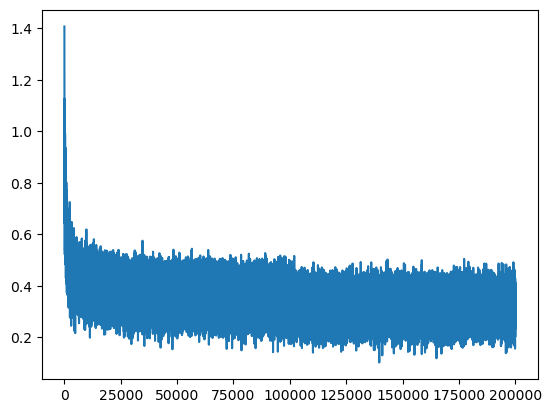

In [11]:
plt.plot(lossi)

In [ ]:
evaluate_nn()

train 2.1215641498565674
val 2.183077573776245


In [ ]:
sample_from_nn()

carmahzati.
hari.
kimir.
reh.
cassanden.
jazhutn.
den.
rha.
kaeli.
ner.
kiah.
maiir.
kaleigh.
ham.
joce.
quinthonova.
alianni.
wanthoniel.
yiigan.
evells.


In [ ]:
# 1) INITIALIZATION
# it is worth noting that the random initialization cause a bit messed up network,
# in fact the first loss is 25.0 and the step after decreases to 2.0. Given the activations
# we can calculate the loss we expect to have:
# 1.1) FIRST LOSS COMPUTATION
# we have 27 characters and at the beginning we expect to have a uniform distribution since
# no character can be tought to be more probable than the others. The loss is given by:
# P(character) = 1/27
# the loss is by definition = -log(P(character)) = -log(1/27) = log(27) = 3.2958
# at initialization we can set all weights at the same value (e.g. 0.0) to be consistent with what
# said above. Logits come from the GEMM of hidden layer and weights and then are added to the bias.
# 1.2) LOSS influencing BIAS and WEIGHTS INITIALIZATION
logits = h @ W2 + b2 
# which comes from: 
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # ensuring that the bias is 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # ensuring that the weights are small
# note: weights cannot be set to 0 

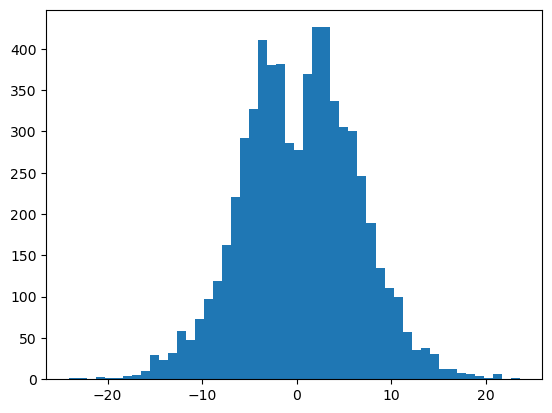

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

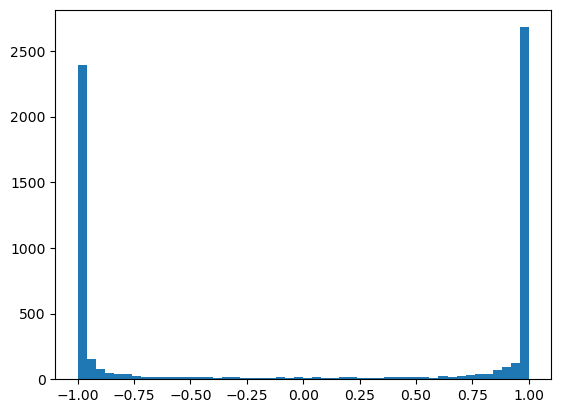

In [ ]:
# VVVVVVVVVVVVVVVVVVVVVVVVVV
# VANISHING GRADIENT PROBLEM
# ^^^^^^^^^^^^^^^^^^^^^^^^^^
plt.hist(h.view(-1).tolist(), 50);
# tanh activation plot is really bad: during brackpropagation in tanh layers we compute the gradient as
# 1 - tanh(t)^2, so if the (forward pass result of tanh) is too close to -1 r +1 
# we have a gradient close to 0. This is called vanishing gradient problem and what happens is that
# the backpropagation is killed and stopped at this tanh layer. 
# This problem happens with most of non-linearity activation functions.

# DEAD NEURONS: this happens when no single example activates the tanh (because weight and bias values
# make the tanh function to always be in the flat region). This is a problem because the neuron will never
# be updated and will NEVER LEARN ANYTHING.

# Btw, the problem is that the pre-activation is too large (-20, +20)!
hpreact = embcat @ W1 + b1
# which comes from: 
b1 = torch.randn(vocab_size,                      generator=g) * 0.01 
W1 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 
# To maintain a bit of entropy it is possible to set weights and bias to really small values and make
# sure that each pre-activation layer is initialized with different values (shown that helps in production).

In [ ]:
# MLP revisited v2
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
train_nn()

      0/ 200000: 3.3069
  10000/ 200000: 2.1900
  20000/ 200000: 2.2707
  30000/ 200000: 2.4296
  40000/ 200000: 1.9041
  50000/ 200000: 2.3865
  60000/ 200000: 2.3392
  70000/ 200000: 2.0873
  80000/ 200000: 2.2595
  90000/ 200000: 2.1146
 100000/ 200000: 1.8817
 110000/ 200000: 2.1622
 120000/ 200000: 1.8919
 130000/ 200000: 2.3128
 140000/ 200000: 2.3481
 150000/ 200000: 2.1759
 160000/ 200000: 1.8034
 170000/ 200000: 1.7760
 180000/ 200000: 1.8991
 190000/ 200000: 1.8666


In [ ]:
evaluate_nn()

train 2.057901382446289
val 2.113706350326538


tensor(0.0036) tensor(0.9943)
tensor(-0.0119) tensor(3.1465)
tensor(-0.0038) tensor(0.9950)


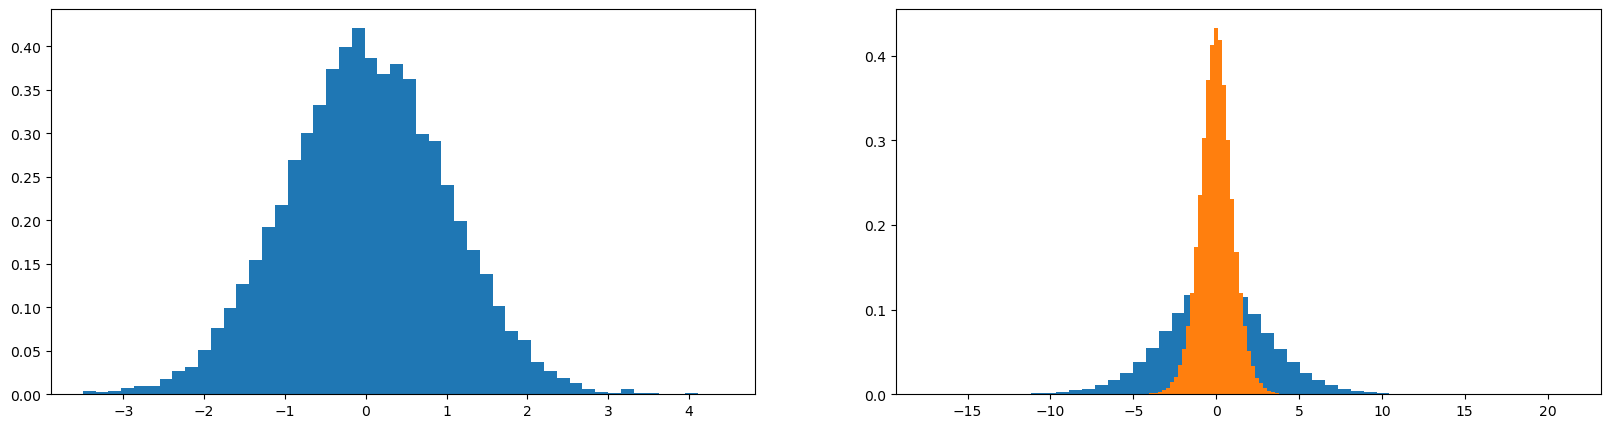

In [ ]:
# VVVVVVVVVVVVVVVVVVVVV
# KAMING INITIALIZATION
# ^^^^^^^^^^^^^^^^^^^^^
# There is a principle which states how to set the scales which are multiplied by weights and biases
# in order to have a good initialization. 
# Since we aim at having a gaussian uniform distribution of the pre-activation values, we are looking 
# for a way to maintain the mean of the distribution to 0 and the std err to 1.

# ! The principle is that the variance of the input and output of each layer should be the same. 

# The idea is to set the weights and biases to a value which is given by the division by the
# square root of the number of neurons in the layer.

# We set the weights to a value which is proportional to gain/sqrt(n). 
# This means that if we have a layer with 100 neurons and we set the weights
# to a value which is proportional to gain/sqrt(100), we will have a good initialization. 
# Gain has defined values for each non-linearity activation function, 
# e.g. for tanh it is 1, for ReLU it is sqrt(2), ...

x = torch.randn(1000, 10) # 1000 examples, 10 neurons (called FAN IN)
w = torch.randn(10, 200) # 10 examples, 200 neurons
y = x @ w 
y_corrected = x @ (w / (10 ** 0.5)) # correct the weights (gain/sqrt(fan_in)-> 1/10 ** 0.5)
print(x.mean(), x.std()) 
print(y.mean(), y.std())
print(y_corrected.mean(), y_corrected.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y_corrected.view(-1).tolist(), 50, density=True);

# Nowadays, the Kaming initialization is used by default in most of the libraries, so we don't have to
# worry about it. However, it is important to understand the principle behind it and how it works.
# In PyTorch, we can use the torch.nn.init module to initialize the weights and biases of the layers.
# For example, we can use the torch.nn.init.kaiming_normal_ function to initialize the weights
# of a layer with a normal distribution with mean 0 and variance 1/n, where n is the number of neurons
# in the layer.
# Each non-linerarity has its suggested gain value (see: https://docs.pytorch.org/docs/stable/nn.init.html)

In [ ]:
# MLP revisited v3
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# kamining initialization parameters
gain_tanh = 5/3
fan_in = n_embd * block_size # number of input neurons (fan-in)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (gain_tanh/(fan_in**0.5)) #* 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0.0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [26]:
train_nn()

      0/ 200000: 2.3340
  10000/ 200000: 2.1325
  20000/ 200000: 1.9218
  30000/ 200000: 2.0864
  40000/ 200000: 2.1897
  50000/ 200000: 2.1622
  60000/ 200000: 2.6629
  70000/ 200000: 1.6356
  80000/ 200000: 2.3372
  90000/ 200000: 2.8039
 100000/ 200000: 2.2746
 110000/ 200000: 2.2937
 120000/ 200000: 2.4773
 130000/ 200000: 2.1066
 140000/ 200000: 1.9376
 150000/ 200000: 2.0154
 160000/ 200000: 2.0892
 170000/ 200000: 1.8959
 180000/ 200000: 1.8348
 190000/ 200000: 1.8684


In [27]:
evaluate_nn()

train 2.057405471801758
val 2.113766670227051


In [6]:
# VVVVVVVVVVVVVVVVVVV
# BATCH NORMALIZATION
# ^^^^^^^^^^^^^^^^^^^
# during train we have the hpreact hidden state and we want it to be roughly a uniform gaussian 
# distribution in order to tanh to work properly. So the idea is to normalize the hpreact (or more
# in general the hidden state) to be a gaussian distribution.


# MLP revisited v4
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12097


In [9]:
def train_nn_batch_norm():
  global bnmean_running, bnstd_running
  # same optimization as last time
  max_steps = 200000
  batch_size = 32
  lossi = []

  for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
      bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
      bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
train_nn_batch_norm()

      0/ 200000: 3.3096
  10000/ 200000: 2.4783
  20000/ 200000: 1.9996
  30000/ 200000: 2.5822
  40000/ 200000: 2.0700
  50000/ 200000: 2.3397
  60000/ 200000: 2.4592
  70000/ 200000: 2.5765
  80000/ 200000: 2.0567
  90000/ 200000: 2.1207
 100000/ 200000: 2.1043
 110000/ 200000: 2.0552
 120000/ 200000: 2.2931
 130000/ 200000: 2.5750
 140000/ 200000: 2.1613
 150000/ 200000: 2.0641
 160000/ 200000: 1.9199
 170000/ 200000: 2.3214
 180000/ 200000: 2.0537
 190000/ 200000: 1.9166


In [ ]:
def estimate_mean_std_after_training():
  # calibrate the batch norm at the end of training. This allows to forward a single example
  # without having to pass a batch of examples.
  with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
  # in the end nobody wants to compute these values after training, so we can estimate them 
  # at "run time"

def evaluate_nn_batch_norm():
  @torch.no_grad() # this decorator disables gradient tracking
  def split_loss(split):
    x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

  split_loss('train')
  split_loss('val')
evaluate_nn_batch_norm()

# Each conv layer which is followed by a batch norm layer does not need to have the bias term.
# This is because the batch norm layer will normalize the output of the conv layer and will add
# a bias term to it. So, we can remove the bias term from the conv layer
# and let the batch norm layer take care of it. This is a common practice in deep learning and it is
# called "batch norm after conv". It is a good practice to use batch norm after conv layers because it
# helps to stabilize the training and to reduce the number of parameters in the model.

train 2.0671029090881348
val 2.1059861183166504


In [ ]:
# loss log:

# Original loss: 
# train 2.1215641498565674
# val 2.183077573776245

# fix softmax confidently wrong (setting w2, b2 to small values):
# train 2.0695888996124268
# val 2.131074905395508

# fix tanh layer too saturated at init (setting w1, b1 to small values):
# train 2.057901382446289
# val 2.113706350326538

# kaiming initialization (setting w1); not a big difference but we have no magic numbers anymore:
# train 2.057405471801758
# val 2.113766670227051

# batch normalization layer:
# train 2.0671029090881348
# val 2.1059861183166504

In [ ]:
"""
SUMMARY:
1. Distribution of the output layers: if you have too confident mispredictions (ending up in steep losses)
 because activations are too large, you can fix it by setting the weights and biases of the output layer 
 to small values to get better loss at the end of training.

2. Control the activations: we don't want activations to squash to 0 or explode to infinity otherwise you
 could end up with messy behavior with the non-linearities layer.

3. Capitalizing what above, we aim to have roughly gaussian activations throughout the network. To do so,
 we have to initialize parameters (weights and biases) to have a good control of their values. 
 To do so, we can use the Batch Normalization layer which can be put after the linear layers/convolutional
 ones and before the non-linearities in order to compute std dev and mean of the data to re-center it to
 get a gaussian distribution.
"""

In [7]:
# let's torch-ify the network:

# same as torch.nn.Linear
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    # fan_in: number of input neurons
    # fan_out: number of output neurons
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    # return the parameters of the layer
    return [self.weight] + ([] if self.bias is None else [self.bias])
  

# same as torch.nn.BatchNorm1d
class BatchNorm1D:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backpropagation
    self.gamma = torch.ones(dim)  # scale
    self.beta = torch.zeros(dim)  # shift
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    
  def __call__(self, x):
    # calculate the forward pass
    if self.training: # training mode
      xmean = x.mean(dim=0, keepdim=True) # batch mean
      xvar = x.var(dim=0, keepdim=True) # batch variance
    else: # evaluation mode
      xmean = self.running_mean
      xvar = self.running_var
    
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
    self.out = self.gamma * xhat + self.beta  # scale and shift

    # update the buffers
    if self.training:
      with torch.no_grad(): # no maintaining a tensors graph for these tensors
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    # return the parameters of the layer
    return [self.gamma, self.beta]
  

class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []
  

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1D(n_hidden), Tanh(), # let's put BatchNorm before Non-Linearty layers
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1D(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1D(vocab_size)
]

with torch.no_grad():
  # last layer (softmax): make less confident
  #layers[-1].weight *= 0.1

  # once introduced batch norm layer we have to make less confident the gamma parameter
  layers[-1].gamma *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= (5/3) 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47551


In [9]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


'\nBefore BatchNorm (high saturation values): \nlayer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%\nlayer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%\nlayer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%\nlayer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%\nlayer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%\n'

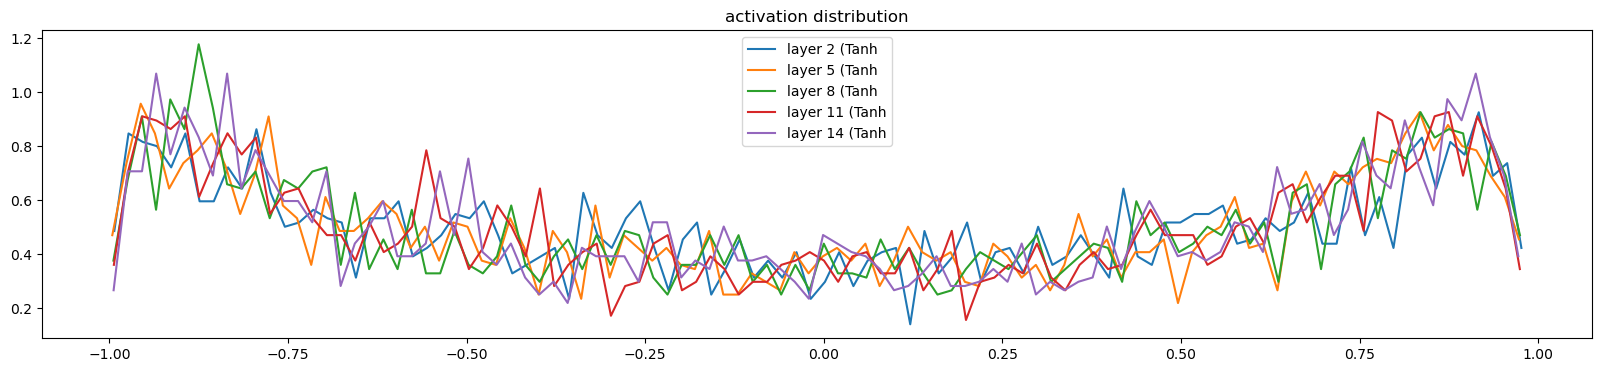

In [ ]:
# Stats of FORWARD PASS ACTIVATIONS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

"""
Before BatchNorm (high saturation values): 
layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%
"""

layer 2 (      Tanh): mean +0.000000, std 3.682950e-03
layer 5 (      Tanh): mean -0.000000, std 3.262606e-03
layer 8 (      Tanh): mean -0.000000, std 2.973729e-03
layer 11 (      Tanh): mean +0.000000, std 2.741107e-03
layer 14 (      Tanh): mean -0.000000, std 2.584293e-03


'Before BatchNorm (): \nlayer 1 (      Tanh): mean +0.000024, std 3.353992e-03\nlayer 3 (      Tanh): mean +0.000012, std 3.157345e-03\nlayer 5 (      Tanh): mean -0.000004, std 2.925863e-03\nlayer 7 (      Tanh): mean +0.000036, std 2.715700e-03\nlayer 9 (      Tanh): mean +0.000020, std 2.308167e-03\n'

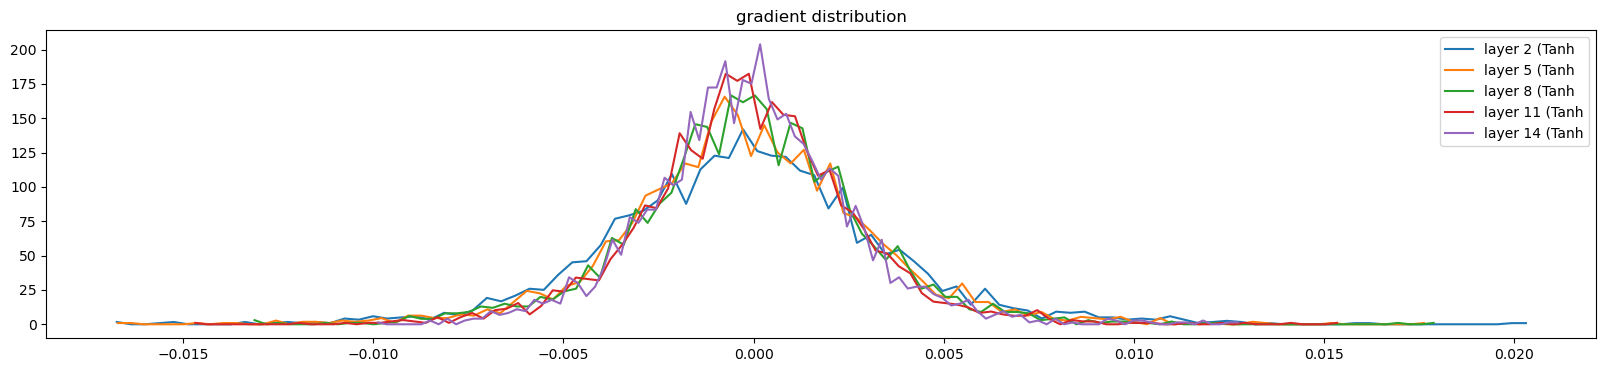

In [ ]:
# stats of BACKWARD PASS GRADIENTS
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

"""
Before BatchNorm (mean was more "sparse"): 
layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157345e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03
"""

weight   (27, 10) | mean +0.000000 | std 1.019883e-02 | grad:data ratio 1.018844e-02
weight  (30, 100) | mean +0.000092 | std 8.238419e-03 | grad:data ratio 2.635835e-02
weight (100, 100) | mean +0.000031 | std 7.318100e-03 | grad:data ratio 4.377137e-02
weight (100, 100) | mean -0.000019 | std 6.662020e-03 | grad:data ratio 3.949894e-02
weight (100, 100) | mean -0.000019 | std 5.821514e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445292e-03 | grad:data ratio 3.243364e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281257e-02


'\nBefore BatchNorm (high saturation values): \nweight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189150e-02\nweight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02\nweight (100, 100) | mean +0.000033 | std 7.821214e-03 | grad:data ratio 4.653364e-02\nweight (100, 100) | mean -0.000107 | std 6.655622e-03 | grad:data ratio 3.925852e-02\nweight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02\nweight (100, 100) | mean -0.000077 | std 5.075621e-03 | grad:data ratio 3.015269e-02\nweight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01\n'

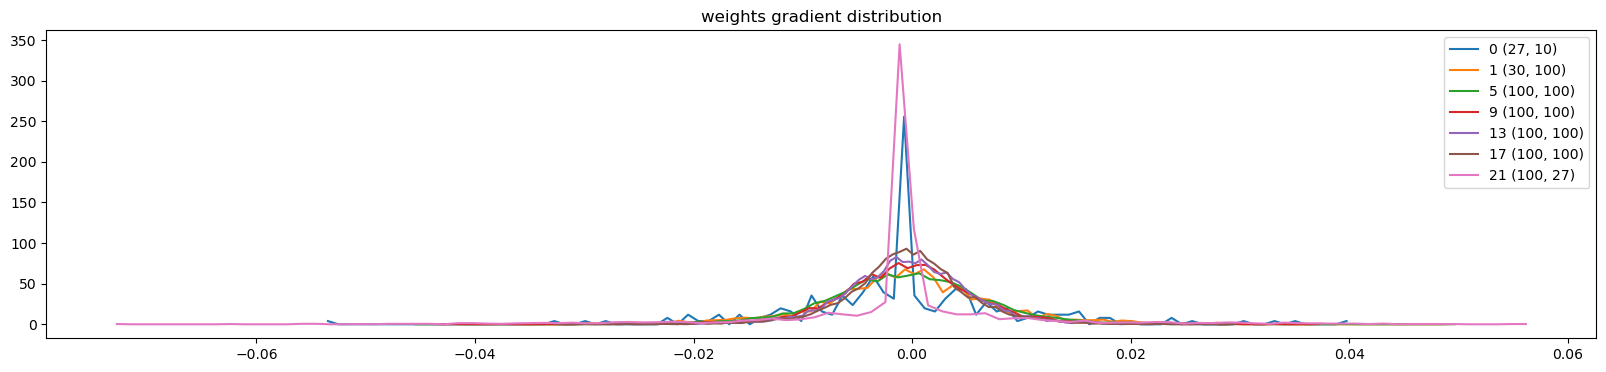

In [ ]:
# Weights that are going to be updated as result of Stochastic Gradient Descent
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# gradient to data ratio is quite important and is good when is is << 0.
# This means that the gradient order of magnitude is much smaller than the data, which is a good sign.
# In this case the last layer sucks a bit all of this because we are not using
# a optimizer during the training.

"""
Before BatchNorm (high saturation values): 
weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189150e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821214e-03 | grad:data ratio 4.653364e-02
weight (100, 100) | mean -0.000107 | std 6.655622e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075621e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01
"""

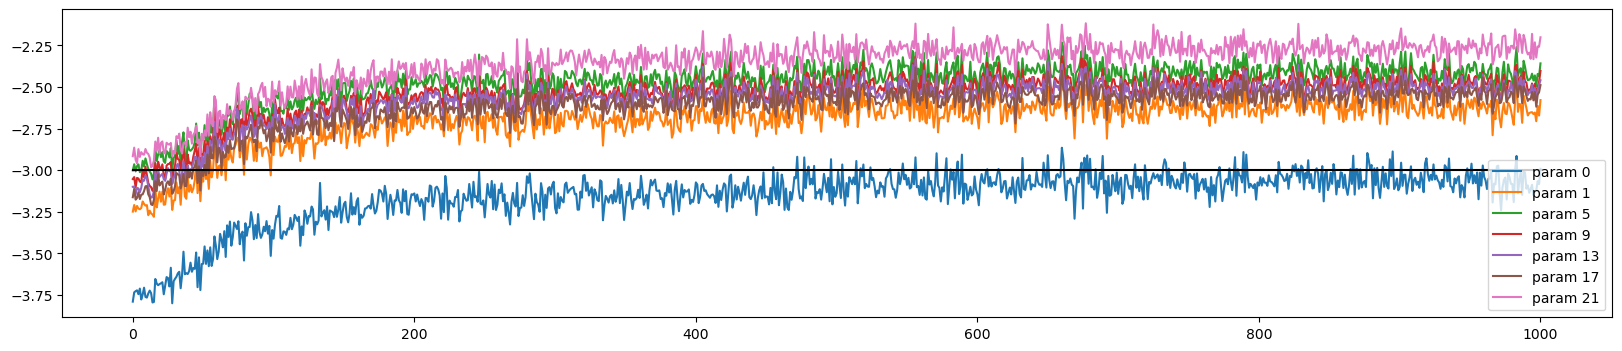

In [ ]:
# Most importantly the UPDATE/DATA RATIO should be checked ('ud' in our case).
# It tells how great the updates are compared to the data, 
# which can indicate if the model is learning effectively.

# If curves are too high, then heuristically probably the learning rate is too high,
# curves are too low otherwise

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # !! these ratios should be ~1e-3, indicate on plot
plt.legend(legends);